In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import timesfm
import multiprocessing

import torch
from torch import Tensor
import torch.nn.functional as F
from torch import nn
from torch.distributions import (Normal, StudentT, Poisson)
from uni2ts.distribution.negative_binomial import (NegativeBinomial)
from uni2ts.distribution import (MixtureOutput, 
                                 NormalOutput, 
                                 StudentTOutput,
                                LaplaceOutput, 
                                NormalFixedScaleOutput,
                                NegativeBinomialOutput, 
                                LogNormalOutput)
from utils.data_loader import create_cached_tsmixup_datasets
from load_cached_features import *
from timesfm.pytorch_patched_decoder import ResidualBlock
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import stdtrit
from scipy.stats import (poisson, nbinom)
from pytorch_forecasting.metrics.quantile import QuantileLoss
# from utils.utils import load_test_data
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 33  # batch size: any positive integer
TEST = 100  # test set length: any positive integer
context_len = 512
pred_len = 128
device = 'cuda:3'

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0].


In [2]:
# Loading tsmixup dataset
train_dataset, val_dataset = create_cached_tsmixup_datasets(
        max_samples=300000,
        context_length=512,
        prediction_length=128, # 1 or 128
        num_workers=16,
        cache_dir="/extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/",
        processed_cache_path="/extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/tsmixup_processed_300000_512_128.pkl",
        batch_size=4000
    )

def load_dataset(dataset, ts=1000, pred_length=1, ctx_len=512):
    if dataset == 'tsmixup':
        x = []
        y = []
        for i in range(ts) if isinstance(ts, int) else ts:
            val_dict = val_dataset[i]
            x.append(val_dict['past_values'])
            y.append(val_dict['future_values'])
        x = torch.stack(x)[:, -ctx_len:]
        y = torch.stack(y)[:,:pred_length]
        
    else:
        dataset_path = f"/extra/datalab_scratch0/ctadler/time_series_models/ts_foundation_calibration/data/{dataset}/y_{dataset}.csv"
        timestamp_column = "ds"

        data = pd.read_csv(
            dataset_path,
            parse_dates=[timestamp_column],
            index_col=0
        )

        x = []
        for id, vals in data.groupby('unique_id'):
            x.append(torch.from_numpy(vals['y'].to_numpy(np.float32)))
        x = torch.stack(x)

    if dataset != 'tsmixup':
        y = x[:,ctx_len:ctx_len+pred_length]
        x = x[:,:ctx_len]
    return x, y

tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend='gpu',
        per_core_batch_size=64,
        context_len=context_len,  # currently max supported
        horizon_len=pred_len,  # number of steps to predict
        input_patch_len=32,  # fixed parameters
        output_patch_len=128,
        num_layers=50,
        model_dims=1280,
        use_positional_embedding=False,
        point_forecast_mode='mean',
        device=device,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
)

🚀 CREATING CACHED TSMIXUP DATASETS
📂 Found existing processed data at /extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/tsmixup_processed_300000_512_128.pkl
⚡ Loading preprocessed data from cache...
✅ Loaded 172,454 preprocessed samples
📅 Cache created: 2025-08-22 13:11:48

📊 DATASET SUMMARY:
  Total processed samples: 172,454
  Context length: 512
  Prediction length: 128
🔀 Shuffling data...
📈 Data split:
  Training samples: 155,208
  Validation samples: 17,246
  Train ratio: 90.0%
🏗️  Creating PyTorch datasets...
🏗️  Dataset created with 155,208 samples
📊 Augmentation: ON
📈 Dataset Statistics (from 1000 samples):
  Sequence lengths: min=640, max=2046, mean=1318
  Value ranges: min=-48.3022, max=72.0737
  Value stats: mean=0.8625, std=2.7795
🏗️  Dataset created with 17,246 samples
📊 Augmentation: OFF
📈 Dataset Statistics (from 1000 samples):
  Sequence lengths: min=640, max=2047, mean=1307
  Value ranges: min=-17.3232, max=473.9922
  Va

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
# Load Training Dataset
train_ds = FullLatentShardDataset("./data/timesfm_cache_last_fp16_old/last_shard_*.pt")

/extra/datalab_scratch0/ctadler/time_series_models/tsfm_head_calibration/load_cached_features.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(f, map_loca

In [4]:
class MixtureHead(nn.Module):
    """
    Wrap a backbone (e.g., ResidualBlock) and a uni2ts DistrParamProj derived from MixtureOutput.
    Forward returns the parameter PyTree ready to instantiate a Mixture distribution.
    """
    def __init__(self, in_features: int, hidden_dims: int, horizon_len: int, mixture_output: MixtureOutput):
        super().__init__()
        # Your backbone to process latents
        self.backbone = ResidualBlock(
            input_dims=in_features,
            output_dims=in_features,       # keep embedding size unchanged
            hidden_dims=hidden_dims,
        )
        # Project backbone features -> mixture parameters for each horizon step
        self.param_proj = mixture_output.get_param_proj(
            in_features=in_features,
            out_features=tuple(horizon_len for _ in range(len(mixture_output.components))),      # produce per-step parameters
            # You can pass proj_layer/kwargs if you want a different projector
        )
        self.mixture_output = mixture_output

    def forward(self, latents: torch.Tensor, out_feat_size: torch.Tensor):
        """
        latents: [B, D] or [B, D'] depending on TimesFM latent shape you used elsewhere
        returns: pytree of parameters (already passed through domain_map, squeezed to [B, H])
        """
        h = self.backbone(latents)
        params = self.param_proj(h, out_feat_size)  # PyTree with shapes [B, H, param_dim] -> domain_map squeezes to [B, H]
        return params

In [5]:
def get_mask(latents: Tensor, labels: Tensor, max_val: int, min_val: int):
    nan_mask = ~torch.isfinite(latents) # if nan
    clamp_mask = (labels > max_val) | (labels < min_val) # if outside min/max
    mask = ~(torch.any(nan_mask, dim=1) | torch.any(clamp_mask, dim=1))
    return mask

def get_preds(model: nn.Module, latents: Tensor, horizon_len: int = 128, output_dims: int = 1,
              reshape: bool = True):
    out = model(latents)  # [B, horizon_len * output_dims]
    if reshape:
        b, _ = out.shape
        out = out.view(b, horizon_len, output_dims)  # [B, H, D]
    return out

def get_batch(dataset: torch.utils.data.Dataset, batch_num: int, batch_size: int, device: str):
    latents, stats, labels = [], [], []
    for i in range(batch_size):
        dataset_ind = batch_num + i
        latent, stat, label = dataset[dataset_ind]
        latents.append(latent)
        stats.append(stat)
        labels.append(label)
    latents = torch.stack(latents).to(device).float()
    stats   = torch.stack(stats).to(device)
    labels  = torch.stack(labels).to(device)
    return latents, stats, labels

def mixture_quantiles_by_sampling(dist, qs, num_samples=4096):
    # dist: uni2ts.mixture.Mixture distribution, batch shape [B, H]
    # qs: sequence like [0.1, 0.5, 0.9]
    with torch.no_grad():
        samples = dist.sample((num_samples,))  # [S, B, H]
        # torch.quantile expects a tensor of probs on same device
        q_tensor = torch.tensor(qs, device=samples.device, dtype=samples.dtype)
        q_vals = torch.quantile(samples, q_tensor, dim=0)  # [Q, B, H]
    return q_vals  # [Q, B, H]

def latent_forecast(pred_head: nn.Module, latents: Tensor, horizon_len: int, head_type: str, 
                    output_dims: int | None = None, labels: Tensor | None = None, 
                    mu0: Tensor | None = None, sigma0: Tensor | None = None,
                    quantiles: list[float] | None = None, forecast: bool = True, 
                    mixture_output: MixtureOutput | None = None):
    if quantiles == None:
        quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    eps = 1e-6
    results = {}
    if output_dims == None:
        output_dims_dict = {"mse": 1, "gaussian": 2, "poisson": 1, "neg_binom": 2, "studentst": 3, 
                            "quantiles": 9, "mixture": 128}
        output_dims = output_dims_dict[head_type]
    
    if head_type != "mixture":
        out = get_preds(pred_head, latents, horizon_len, output_dims) # [B, H, D]
    if head_type == "mse":
        pred = out[:, :, 0] # [B, H]
        if torch.is_tensor(mu0) and torch.is_tensor(sigma0):
            pred = pred * sigma0[:, None] + mu0[:, None]
        if torch.is_tensor(labels):
            loss = F.mse_loss(pred, labels)
            results["loss"] = loss
        if forecast:
            results["mean"] = pred.detach().cpu()
            results["median"] = pred.detach().cpu()

    elif head_type == "quantiles":
        pred = out # [B, H, Q]
        if torch.is_tensor(mu0) and torch.is_tensor(sigma0):
            pred = pred * sigma0[:, None, None] + mu0[:, None, None]
        if torch.is_tensor(labels):
            loss = QuantileLoss(quantiles).loss(pred, labels).mean()
            results["loss"] = loss
        if forecast:
            results["median"] = pred[:, :, 4].detach().cpu()
            results["mean"] = pred[:, :, 4].detach().cpu()
            results["quantiles"] = pred.detach().cpu()
            
    elif head_type == "mixture":
        assert mixture_output is not None, "mixture_output must be provided for head_type='mixture'"

        # 1) Predict mixture parameters
        # pred_head is MixtureHead and returns a PyTree with keys:
        #   "weights_logits" -> [B, H, K]
        #   "components" -> list of dicts with the per-component parameters ([B, H])
        out_feat_size = torch.full([latents.shape[0]], horizon_len, dtype=int, device=latents.device)
        params = pred_head(latents, out_feat_size)

        # 2a) TRAINING: If you trained on normalized labels (continuous):
        #     Use dist on normalized space (no affine transform).
        # 2b) TRAINING (counts): keep labels as integers and use as-is.
        if torch.is_tensor(mu0) and torch.is_tensor(sigma0):
            dist = mixture_output.distribution(
                params,
                loc=mu0[:, None],     # [B, 1] -> broadcast to [B, H]
                scale=sigma0[:, None]
            )
        else:
            dist = mixture_output.distribution(params)

        if torch.is_tensor(labels):
            loss = -dist.log_prob(labels).mean()
            results["loss"] = loss

        if forecast:
            # 3) FORECAST: return distribution in original units by affine transform (if you used normalized training)
            with torch.no_grad():
                mean = dist.mean.detach().cpu()  # [B, H]
                # quantiles via sampling
                median_quantiles = [0.5] + quantiles
                q_vals = mixture_quantiles_by_sampling(dist, median_quantiles, num_samples=4096).cpu()  # [3, B, H]
                results["mean"] = mean
                results["median"] = q_vals[0] # could be misaligned
                results["quantiles"] = q_vals[1:]

    else: # distribution loss
        if head_type == "gaussian":
            pred_mu = out[:, :, 0]
            pred_std = F.softplus(out[:, :, 1]) + eps
            if torch.is_tensor(mu0) and torch.is_tensor(sigma0):
                pred_mu = pred_mu * sigma0[:, None] + mu0[:, None]
                pred_std = pred_std * sigma0[:, None]
            distribution = Normal(pred_mu, pred_std)

        elif head_type == "poisson":
            if torch.is_tensor(mu0) and torch.is_tensor(sigma0):
                pred_lambda = F.softplus(out[:, :, 0] + torch.log(mu0[:, None].clamp_min(eps))) + eps
            else:
                pred_lambda = F.softplus(out[:, :, 0]) + eps
            distribution = Poisson(pred_lambda)

        elif head_type == "neg_binom":
            pred_mu =  torch.exp(out[:, :, 0]) + eps # any real
            pred_r = F.softplus(out[:, :, 1])  + eps # dispersion > 0
            if torch.is_tensor(mu0):
                pred_mu = pred_mu * mu0[:, None].clamp_min(eps)
            pred_p = pred_r / (pred_r + pred_mu) # Pytorch/Scipy
            # distribution = NegativeBinomial(total_count=pred_r, probs=pred_p) # Pytorch
            pred_logits = torch.log(pred_mu / pred_r)
            distribution = NegativeBinomial(total_count=pred_r, logits=pred_logits)
            
        elif head_type == "studentst":
            pred_df = F.softplus(out[:, :, 0]) + eps
            pred_mu = out[:, :, 1]
            pred_std = F.softplus(out[:, :, 2]) + eps
            if torch.is_tensor(mu0) and torch.is_tensor(sigma0):
                pred_mu = pred_mu * sigma0[:, None] + mu0[:, None]
                pred_std = pred_std * sigma0[:, None]
            distribution = StudentT(pred_df, loc=pred_mu, scale=pred_std)
        else:
            raise KeyError(f"{head_type} is not a valid distribution or loss")
        if torch.is_tensor(labels):
            if head_type == "poisson":
                loss = F.poisson_nll_loss(pred_lambda, labels, log_input=False)
            else:
                loss = -distribution.log_prob(labels).mean()
            results["loss"] = loss
        if forecast:
            results["mean"] = distribution.mean.detach().cpu()
            if head_type in  ("studentst", "poisson", "neg_binom"):
                median_quantiles = [0.5] + quantiles
                p = torch.tensor(median_quantiles)[:, None, None] * \
                    torch.ones((len(median_quantiles), out.shape[0], out.shape[1]))
                if head_type == "studentst":
                    preds = stdtrit(pred_df.detach().cpu().repeat(len(median_quantiles), 1, 1), p)
                    preds = preds * pred_std.detach().cpu() + pred_mu.detach().cpu()
                if head_type == "poisson":
                    preds = poisson.ppf(p, pred_lambda.detach().cpu().repeat(len(median_quantiles), 1, 1))
                if head_type == "neg_binom":
                    preds = nbinom.ppf(p, pred_r.detach().cpu().repeat(len(median_quantiles), 1, 1), 
                                       pred_p.detach().cpu().repeat(len(median_quantiles), 1, 1))
                results["median"] = preds[0]
                results["quantiles"] = preds[1:]

            else:
                results["median"] = distribution.icdf(0.5*torch.ones_like(out[:,:,0])).detach().cpu()
                quantiles_torch = torch.tensor(quantiles).repeat(out.shape[0], out.shape[1], 1)
                results["quantiles"] = distribution.icdf(quantiles_torch).detach().cpu()

    return results
            


In [6]:
# Standard Head
head_type = "studentst"
patch_len = 32
hidden_size = 1280
intermediate_size = 1280
output_dims = 1
horizon_len = 96
tot_iters = 2097152
batch_size = 512
output_dims_dict = {"mse": 1, "gaussian": 2, "poisson": 1, "neg_binom": 2, "studentst": 3, "quantiles": 9, "mixture": None}
# Quantiles, StudentsT, Gaussian, MOIRAI Mixture, Gaussian Mixture, Spline, Chronos Categorical
count_heads = ("poisson", "neg_binom")
output_dims = output_dims_dict[head_type]

# Mixture Distribution

if head_type == "mixture":
    # MOIRAI V1 Mixture Components
    components = [ 
        StudentTOutput(),
        NormalFixedScaleOutput(),
        NegativeBinomial(),
        LogNormalOutput(),
    ]
    mixture_output = MixtureOutput(components)
    K = len(components)
    pred_head = MixtureHead(
            in_features=hidden_size,
            hidden_dims=intermediate_size,
            horizon_len=horizon_len,
            mixture_output=mixture_output
        ).to(device).train()
else:
    mixture_output = None
    pred_head = ResidualBlock(
            input_dims=hidden_size,
            output_dims=horizon_len*output_dims,
            hidden_dims=intermediate_size,
        ).to(device).train()
save_path = f"models/timesfm_{head_type}_head.pt"

# pred_head = torch.nn.Linear(hidden_size, horizon_len*output_dims).to(device).train()

optimizer = torch.optim.AdamW(pred_head.parameters(), lr=3e-4, weight_decay=1e-2)
grad_clip = 1.0
scaler = torch.amp.GradScaler()

logvar_min, logvar_max = -10.0, 10.0              # normalized log-variance bounds
sigma_floor, sigma_ceiling = 1e-6, 1e6            # per-sample sigma bounds in original units
var_floor, var_ceiling = 1e-12, 1e12              # final variance bounds
min_std_norm = 0.05                               # floor on normalized std (pre sigma scaling)
max_label = 1000                                  # If Label is greater remove as an outlier
min_label = -1000 if head_type not in count_heads else 0

training_loss = []
tfm_loss = []
run_tfm = False

In [26]:
# Training setup
loss_batch = []
tfm_loss_batch = []
for epoch in tqdm(range(3), desc="Epochs", disable=True):
    pbar = tqdm(range(0, tot_iters, batch_size), desc=f"Epoch: {epoch}", leave=True)
    for batch_num in pbar:
        latents, stats, labels = get_batch(train_ds, batch_num, batch_size, device)
        mask = get_mask(latents, labels, max_label, min_label)

        if torch.any(mask == 0):
            latents = latents[mask]
            stats = stats[mask]
            labels = labels[mask]
            # print(f"Reduced batch_size from {batch_size} to {latents.shape[0]}")

        # Set up norm
        mu0    = stats[:, 0].float()                                # [B]
        sigma0 = stats[:, 1].float()                                # [B]
        labels_norm = (labels.float() - mu0[:, None]) / sigma0[:, None]       # [B, H]

        optimizer.zero_grad(set_to_none=True)

        results = latent_forecast(pred_head, latents, horizon_len, head_type, 
                    output_dims, forecast=False,
                    labels=labels if head_type in count_heads else labels_norm,
                    mu0=mu0 if head_type in count_heads else None,
                    sigma0=sigma0 if head_type in count_heads else None,
                    mixture_output=mixture_output)
        loss = results["loss"]
        loss_batch.append(loss.item())

        # Backward with AMP
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(pred_head.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()

        if run_tfm:
            with torch.no_grad():            
                output_ts = tfm._model.horizon_ff_layer(latents)
                b, _ = output_ts.shape
                output_ts = output_ts.view(b, 128, 10)[:, :horizon_len, 0]
                tfm_loss_batch.append(F.mse_loss(output_ts, labels_norm).item())

        # print(f"isfinite: latents {torch.isfinite(latents).all()} count: {torch.count_nonzero(torch.logical_not(torch.isfinite(latents)))}")
        # print(f"isfinite: mu_pred {torch.isfinite(mu_pred).all()}, min {mu_pred.min():.2e} max {mu_pred.max():.2e} q(0.999) {torch.quantile(mu_pred, 0.999):.2e}")
        # print(f"isfinite: y {torch.isfinite(y).all()}, min {y.min():.2e} max {y.max():.2e} q(0.999) {torch.quantile(y, 0.999):.2e}")
        # print(f"isfinite: labels {torch.isfinite(labels).all()}, min {labels.min():.2e} max {labels.max():.2e} q(0.999) {torch.quantile(labels, 0.999):.2e}")
        # print(f"isfinite: sigma {torch.isfinite(sigma).all()}, min {sigma.min():.2e} max {sigma.max():.2e} q(0.999) {torch.quantile(sigma, 0.999):.2e}")
        
        # Logging
        if batch_num % (batch_size * 1024) == 0:
            train_med_loss = np.median(np.array(loss_batch))
            loss_batch = []
            pbar.set_description(f"epoch: {epoch} batch_num: {batch_num // batch_size}/{tot_iters // batch_size} loss: {train_med_loss:.4f}") 
            # print(f"epoch: {epoch} batch_num: {batch_num // batch_size} loss: {train_med_loss:.4f}")
            training_loss.append(train_med_loss)
            if run_tfm:
                tfm_med_loss = np.median(np.array(tfm_loss_batch))
                tfm_loss_batch = []
                print(f"TimesFM mse: {tfm_med_loss:.4f}")
                tfm_loss.append(tfm_med_loss)

torch.save(pred_head.state_dict(), save_path)

epoch: 2 batch_num: 3072/4096 loss: 1.0990: 100%|██████████| 4096/4096 [00:38<00:00, 105.52it/s]


In [ ]:
# Plot Training Loss
plt.figure(figsize=(10,5))
plt.plot(training_loss, label="Custom Head")
if run_tfm:
    plt.plot(tfm_loss, label="Timesfm")
plt.legend()
plt.xlabel("Mini batch")
plt.ylabel("Median MSE Loss")
plt.title("Training Loss")
plt.ylim(top=np.quantile(training_loss, 0.99))
plt.show()

/tmp/ipykernel_802581/3576761678.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pred_head.load_state_dict(torch.load(save_path))


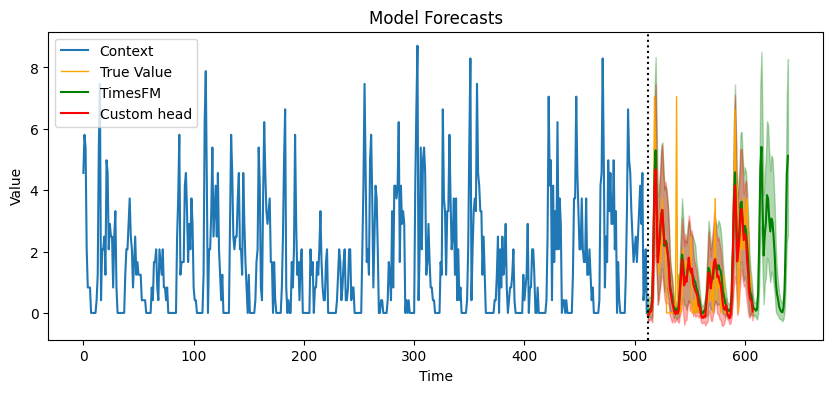

: 

In [ ]:
# Plot Examples
pred_head.load_state_dict(torch.load(save_path))
x, y = load_dataset('tsmixup', 100, pred_length=horizon_len, ctx_len=context_len)
# Load Latents
tfm_pred, tfm_quantiles, (latents, stats) = tfm.forecast(x, get_stacked_transformer=True)
latents = latents[:, -1, :].to(device)

mu0    = stats[:, 0].float()                                # [B]
sigma0 = stats[:, 1].float()
results = latent_forecast(pred_head, latents, horizon_len, head_type, 
                          output_dims, mu0=mu0, sigma0=sigma0, 
                          mixture_output=mixture_output)
head_pred = results["mean"]
head_q10 = results["quantiles"][0] 
head_q90 = results["quantiles"][-1]

ind = 4
plt.figure(figsize=(10,4))
plt.plot(x[ind], label="Context")
plt.plot(np.arange(y.shape[1]) + context_len, y[ind].detach().cpu(), color='orange', label='True Value', lw=1)

plt.plot(np.arange(tfm_pred.shape[1]) + context_len, tfm_pred[ind], color='green', label='TimesFM')
plt.fill_between(np.arange(tfm_pred.shape[1]) + context_len, tfm_quantiles[ind, :, 1], tfm_quantiles[ind, :, -1], color='green', alpha=0.3)

plt.plot(np.arange(head_pred.shape[1]) + context_len, head_pred[ind].detach().cpu(), color='red', label='Custom head')
plt.fill_between(np.arange(head_pred.shape[1]) + context_len, head_q10[ind], head_q90[ind], color='red', alpha=0.3)

plt.axvline(context_len, color="black", ls=':')
plt.title("Model Forecasts")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()